<h1>Code

<h3>What this does:

1. Backbone: ResNet18 frozen (can later fine-tune deeper
layers)

2. Outputs: Person ID (multi-class) + Forgery (binary)

3. Training: combined loss (person_loss + forgery_loss)

4. History tracking: separate curves for both tasks

5. Evaluation: confusion matrix + classification report for forgery

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# =====================
# CONFIG
# =====================
DATA_DIR = "data/images"
CSV_FILE = "data/metadata.csv"
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 20
LR = 1e-4
NUM_PERSONS = 55  # adjust based on your dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# =====================
# DATASET
# =====================
class SignatureDatasetMulti(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        person_label = torch.tensor(row["person_id"]-1, dtype=torch.long)  # 0-indexed
        forgery_label = torch.tensor(row["is_genuine"], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, person_label, forgery_label

In [ ]:
# =====================
# TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# =====================
# LOAD DATA
# =====================
df = pd.read_csv(CSV_FILE)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["person_id"], random_state=42)

train_dataset = SignatureDatasetMulti(train_df, DATA_DIR, transform=train_transform)
val_dataset = SignatureDatasetMulti(val_df, DATA_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Train samples: 2112, Val samples: 528


In [ ]:
# =====================
# MULTI-TASK MODEL
# =====================
class MultiTaskResNet(nn.Module):
    def __init__(self, base_model, num_persons):
        super().__init__()
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove original FC
        in_features = base_model.fc.in_features
        self.fc_person = nn.Linear(in_features, num_persons)
        self.fc_forgery = nn.Linear(in_features, 2)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        person_out = self.fc_person(x)
        forgery_out = self.fc_forgery(x)
        return person_out, forgery_out

base_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in base_resnet.parameters():
    param.requires_grad = False  # freeze backbone

model = MultiTaskResNet(base_resnet, NUM_PERSONS).to(device)

In [ ]:
# =====================
# LOSS & OPTIMIZER
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.fc_person.parameters()) + list(model.fc_forgery.parameters()), lr=LR)

In [ ]:
# =====================
# TRAINING LOOP WITH HISTORY
# =====================
history = {"train_loss": [], "val_loss": [], "train_acc_person": [], "val_acc_person": [],
           "train_acc_forgery": [], "val_acc_forgery": []}

for epoch in range(1, EPOCHS + 1):
    # --- TRAIN ---
    model.train()
    running_loss, correct_person, correct_forgery, total = 0, 0, 0, 0
    for imgs, person_labels, forgery_labels in train_loader:
        imgs = imgs.to(device)
        person_labels = person_labels.to(device)
        forgery_labels = forgery_labels.to(device)

        optimizer.zero_grad()
        out_person, out_forgery = model(imgs)
        loss_person = criterion(out_person, person_labels)
        loss_forgery = criterion(out_forgery, forgery_labels)
        loss = loss_person + loss_forgery
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, pred_person = torch.max(out_person, 1)
        _, pred_forgery = torch.max(out_forgery, 1)
        correct_person += (pred_person == person_labels).sum().item()
        correct_forgery += (pred_forgery == forgery_labels).sum().item()
        total += imgs.size(0)

    train_loss = running_loss / total
    train_acc_person = correct_person / total * 100
    train_acc_forgery = correct_forgery / total * 100

    # --- VALIDATION ---
    model.eval()
    val_loss, val_correct_person, val_correct_forgery, val_total = 0, 0, 0, 0
    with torch.no_grad():
        for imgs, person_labels, forgery_labels in val_loader:
            imgs = imgs.to(device)
            person_labels = person_labels.to(device)
            forgery_labels = forgery_labels.to(device)

            out_person, out_forgery = model(imgs)
            loss_person = criterion(out_person, person_labels)
            loss_forgery = criterion(out_forgery, forgery_labels)
            loss = loss_person + loss_forgery
            val_loss += loss.item() * imgs.size(0)

            _, pred_person = torch.max(out_person, 1)
            _, pred_forgery = torch.max(out_forgery, 1)
            val_correct_person += (pred_person == person_labels).sum().item()
            val_correct_forgery += (pred_forgery == forgery_labels).sum().item()
            val_total += imgs.size(0)

    val_loss /= val_total
    val_acc_person = val_correct_person / val_total * 100
    val_acc_forgery = val_correct_forgery / val_total * 100

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc_person"].append(train_acc_person)
    history["val_acc_person"].append(val_acc_person)
    history["train_acc_forgery"].append(train_acc_forgery)
    history["val_acc_forgery"].append(val_acc_forgery)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc Person: {train_acc_person:.2f}% | Val Acc Person: {val_acc_person:.2f}% | "
          f"Train Acc Forgery: {train_acc_forgery:.2f}% | Val Acc Forgery: {val_acc_forgery:.2f}%")

print("✅ Multi-task Training Complete")

Epoch 1/20 | Train Loss: 4.7222 | Val Loss: 4.5680 | Train Acc Person: 2.32% | Val Acc Person: 5.68% | Train Acc Forgery: 52.75% | Val Acc Forgery: 54.17%
Epoch 2/20 | Train Loss: 4.4267 | Val Loss: 4.3362 | Train Acc Person: 8.76% | Val Acc Person: 14.39% | Train Acc Forgery: 61.17% | Val Acc Forgery: 58.90%
Epoch 3/20 | Train Loss: 4.2178 | Val Loss: 4.1209 | Train Acc Person: 18.42% | Val Acc Person: 28.03% | Train Acc Forgery: 64.58% | Val Acc Forgery: 63.07%
Epoch 4/20 | Train Loss: 4.0076 | Val Loss: 3.9252 | Train Acc Person: 31.16% | Val Acc Person: 39.58% | Train Acc Forgery: 65.81% | Val Acc Forgery: 63.45%
Epoch 5/20 | Train Loss: 3.8135 | Val Loss: 3.7366 | Train Acc Person: 41.62% | Val Acc Person: 51.33% | Train Acc Forgery: 67.95% | Val Acc Forgery: 69.70%
Epoch 6/20 | Train Loss: 3.6386 | Val Loss: 3.5611 | Train Acc Person: 51.61% | Val Acc Person: 57.20% | Train Acc Forgery: 69.93% | Val Acc Forgery: 69.32%
Epoch 7/20 | Train Loss: 3.4695 | Val Loss: 3.3889 | Train Ac

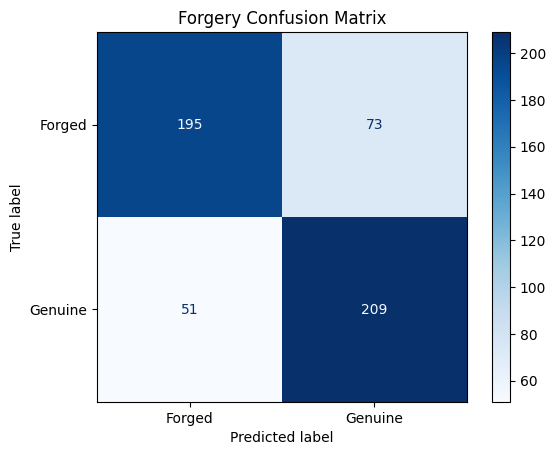


Forgery Classification Report:

              precision    recall  f1-score   support

      Forged       0.79      0.73      0.76       268
     Genuine       0.74      0.80      0.77       260

    accuracy                           0.77       528
   macro avg       0.77      0.77      0.76       528
weighted avg       0.77      0.77      0.76       528



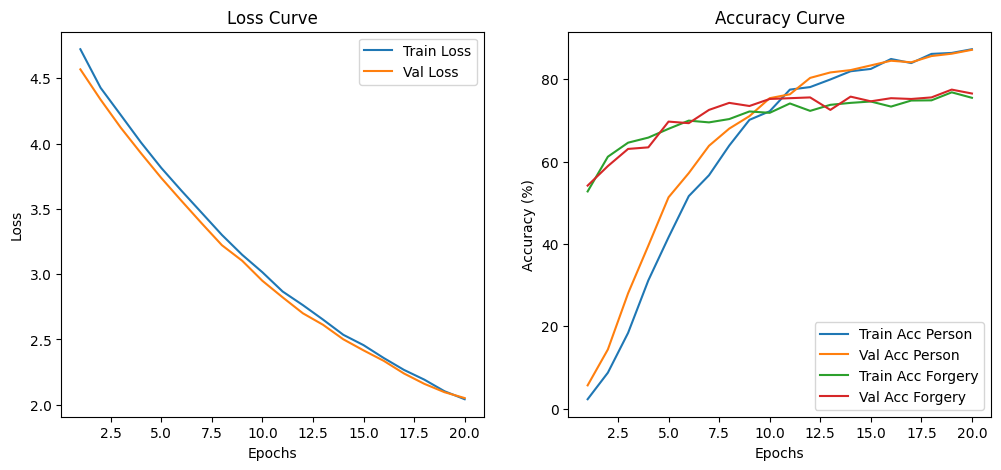

In [ ]:
# =====================
# EVALUATION
# =====================
model.eval()
y_true_person, y_pred_person = [], []
y_true_forgery, y_pred_forgery = [], []

with torch.no_grad():
    for imgs, person_labels, forgery_labels in val_loader:
        imgs = imgs.to(device)
        person_labels = person_labels.to(device)
        forgery_labels = forgery_labels.to(device)

        out_person, out_forgery = model(imgs)
        _, pred_person = torch.max(out_person, 1)
        _, pred_forgery = torch.max(out_forgery, 1)

        y_true_person.extend(person_labels.cpu().numpy())
        y_pred_person.extend(pred_person.cpu().numpy())
        y_true_forgery.extend(forgery_labels.cpu().numpy())
        y_pred_forgery.extend(pred_forgery.cpu().numpy())

# ---- Confusion Matrix & Report for Forgery ----
cm_forgery = confusion_matrix(y_true_forgery, y_pred_forgery)
disp = ConfusionMatrixDisplay(cm_forgery, display_labels=["Forged", "Genuine"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Forgery Confusion Matrix")
plt.show()

print("\nForgery Classification Report:\n")
print(classification_report(y_true_forgery, y_pred_forgery, target_names=["Forged", "Genuine"]))

# ---- OPTIONAL: Accuracy curves ----
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_acc_person"], label="Train Acc Person")
plt.plot(epochs_range, history["val_acc_person"], label="Val Acc Person")
plt.plot(epochs_range, history["train_acc_forgery"], label="Train Acc Forgery")
plt.plot(epochs_range, history["val_acc_forgery"], label="Val Acc Forgery")
plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy Curve")
plt.legend(); plt.show()


A ready-to-use inference function for your multi-task ResNet18 model. It will take a new signature image and output both:

1. Predicted person ID

2. Genuine / Forged

In [ ]:
def predict_signature_person_forgery(model, img_path, transform, device):
    """
    Predicts the signer and forgery status of a signature image.

    Args:
        model: trained multi-task model
        img_path: path to the signature image
        transform: torchvision transforms applied to the image
        device: 'cuda' or 'cpu'

    Returns:
        predicted_person_id (int), predicted_forgery (str)
    """
    model.eval()
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out_person, out_forgery = model(image)
        _, pred_person = torch.max(out_person, 1)
        _, pred_forgery = torch.max(out_forgery, 1)

    predicted_person_id = pred_person.item() + 1  # convert back to 1-indexed
    predicted_forgery = "Genuine" if pred_forgery.item() == 1 else "Forged"

    return predicted_person_id, predicted_forgery


In [ ]:
# -------------------------
#   Example Usage
# -------------------------

test_img = "/content/forgeries_2_1.png"
person_id, forgery_status = predict_signature_person_forgery(
    model, test_img, val_transform, device
)
print(f"Predicted Person ID: {person_id}")
print(f"Forgery Status: {forgery_status}")


Predicted Person ID: 2
Forgery Status: Forged


In [ ]:
torch.save(model.state_dict(), "signature_multitask_resnet18.pth")

---------------------------------------------------------------

<h1>Code 2:

<h2>Model Architecture

This is a Multi-task Convolutional Neural Network (CNN):

Input Layer:

1. Shape (128,128,1) for grayscale signature images.

2. Shared Feature Extractor (CNN layers):

    3 convolution + max pooling blocks:

          Conv2D(32) → MaxPooling2D

          Conv2D(64) → MaxPooling2D

          Conv2D(128) → MaxPooling2D

   Flatten → Dense(256) → Dropout(0.5).

   Learns common features (strokes, curves, textures, etc.).

3. Branch 1 – Person Identification:

      - Dense layer with num_persons neurons, softmax.

      - Task: "Who signed this signature?"

4. Branch 2 – Forgery Detection:

      - Dense layer with 2 neurons, softmax.

      - Task: "Is this signature Genuine or Forged?"

<h3>Model Compilation

1. Optimizer: Adam.

2. Losses:

     categorical_crossentropy for both branches.

3. Metrics:

     Accuracy for both tasks separately.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ---------------------------
# 1. Load dataset
# ---------------------------
data = np.load("signatures_dataset.npz", allow_pickle=True)

X = data["X"]                         # (N, 128, 128, 1)
y_person_ids = data["person_ids"]     # person_id (int)
y_person_names = data["person_names"] # person_name (string)
y_genuine = data["is_genuine"]        # 0/1
y_labels = data["labels"]             # any extra label

print("Shapes:", X.shape, y_person_ids.shape, y_genuine.shape)

# ---------------------------
# 2. Encode labels
# ---------------------------
num_persons = len(np.unique(y_person_ids))

y_persons_oh = to_categorical(y_person_ids - 1, num_classes=num_persons)
y_genuine_oh = to_categorical(y_genuine, num_classes=2)

# ---------------------------
# 3. Train/test split
# ---------------------------
X_train, X_test, y_persons_train, y_persons_test, y_genuine_train, y_genuine_test = train_test_split(
    X, y_persons_oh, y_genuine_oh, test_size=0.2, random_state=42, stratify=y_person_ids
)

# ---------------------------
# 4. Define Multi-task CNN
# ---------------------------
inputs = Input(shape=(128, 128, 1))

x = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

# Branch 1: Person classification
person_output = Dense(num_persons, activation="softmax", name="person_output")(x)

# Branch 2: Genuine/Forged classification
genuine_output = Dense(2, activation="softmax", name="genuine_output")(x)

# Model
model = Model(inputs=inputs, outputs=[person_output, genuine_output])

model.compile(
    optimizer="adam",
    loss={"person_output": "categorical_crossentropy", "genuine_output": "categorical_crossentropy"},
    metrics={"person_output": "accuracy", "genuine_output": "accuracy"}
)

model.summary()

# ---------------------------
# 5. Train
# ---------------------------
history = model.fit(
    X_train,
    {"person_output": y_persons_train, "genuine_output": y_genuine_train},
    validation_data=(X_test, {"person_output": y_persons_test, "genuine_output": y_genuine_test}),
    epochs=10,
    batch_size=32
)


Shapes: (2640, 128, 128, 1) (2640,) (2640,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  8,388,864 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ person_output       │ (None, 55)        │     14,135 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genuine_output      │ (None, 2)         │        514 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,496,185 (32.41 MB)

 Trainable params: 8,496,185 (32.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - genuine_output_accuracy: 0.5171 - genuine_output_loss: 0.8874 - loss: 4.9916 - person_output_accuracy: 0.0127 - person_output_loss: 4.1042 - val_genuine_output_accuracy: 0.6799 - val_genuine_output_loss: 0.6181 - val_loss: 4.2405 - val_person_output_accuracy: 0.1705 - val_person_output_loss: 3.6238
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - genuine_output_accuracy: 0.7011 - genuine_output_loss: 0.6169 - loss: 3.8631 - person_output_accuracy: 0.1716 - person_output_loss: 3.2462 - val_genuine_output_accuracy: 0.6970 - val_genuine_output_loss: 0.5718 - val_loss: 2.5663 - val_person_output_accuracy: 0.5114 - val_person_output_loss: 2.0001
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - genuine_output_accuracy: 0.7361 - genuine_output_loss: 0.5502 - loss: 2.5569 - person_output_accuracy: 0.4559 - person_output_loss: 2.0067 - val_genuine_output_accuracy: 0.7803 - val_genuine_output_loss: 0.4567 - val_loss: 1.6181 - val_perso

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ---------------------------
# Evaluate model on test data
# ---------------------------
test_loss, person_loss, genuine_loss, person_acc, genuine_acc = model.evaluate(
    X_test,
    {"person_output": y_persons_test, "genuine_output": y_genuine_test},
    verbose=1
)

print("\n📊 Test Results:")
print(f"Total loss: {test_loss:.4f}")
print(f"Person ID loss: {person_loss:.4f}, Accuracy: {person_acc:.4f}")
print(f"Genuine/Forgery loss: {genuine_loss:.4f}, Accuracy: {genuine_acc:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - genuine_output_accuracy: 0.8993 - genuine_output_loss: 0.3324 - loss: 0.6061 - person_output_accuracy: 0.9030 - person_output_loss: 0.2771

📊 Test Results:
Total loss: 0.6902
Person ID loss: 0.3488, Accuracy: 0.8902
Genuine/Forgery loss: 0.3731, Accuracy: 0.8902


In [ ]:
# ---------------------------
# Predictions
# ---------------------------
y_pred_person_probs, y_pred_genuine_probs = model.predict(X_test)

# Person predictions
y_pred_person = np.argmax(y_pred_person_probs, axis=1)
y_true_person = np.argmax(y_persons_test, axis=1)

# Genuine predictions
y_pred_genuine = np.argmax(y_pred_genuine_probs, axis=1)
y_true_genuine = np.argmax(y_genuine_test, axis=1)

# ---------------------------
# Reports
# ---------------------------
print("\nPerson ID Classification Report:")
print(classification_report(y_true_person, y_pred_person))

print("\nGenuine/Forgery Classification Report:")
print(classification_report(y_true_genuine, y_pred_genuine))

print("\nConfusion Matrix (Person ID):")
print(confusion_matrix(y_true_person, y_pred_person))

print("\nConfusion Matrix (Genuine/Forgery):")
print(confusion_matrix(y_true_genuine, y_pred_genuine))


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Person ID Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.91      1.00      0.95        10
           2       0.89      0.89      0.89         9
           3       0.78      0.78      0.78         9
           4       0.80      0.89      0.84         9
           5       0.82      1.00      0.90         9
           6       1.00      0.40      0.57        10
           7       1.00      1.00      1.00         9
           8       0.83      1.00      0.91        10
           9       1.00      0.90      0.95        10
          10       1.00      0.90      0.95        10
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         9
          13       0.82      0.90      0.86        10
          14       1.00      0.90      0.95        10
          15       1.00      1.00      1.00        10
       

In [ ]:
model.save("signature_verification_model.h5")
print("✅ Model saved as signature_verification_model.h5")


✅ Model saved as signature_verification_model.h5


In [ ]:
from google.colab import files

# Save again (just to be sure)
model.save("signature_verification_model.h5")

# Download to local system
files.download("signature_verification_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import requests
from io import BytesIO
from PIL import Image

# Mapping person_id → person_name
person_id_to_name = {pid: name for pid, name in zip(y_person_ids, y_person_names)}

def preprocess_single_image(img_path_or_url):
    # Load image from URL or local path
    if img_path_or_url.startswith("http"):
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content)).convert("L")  # grayscale
    else:
        img = Image.open(img_path_or_url).convert("L")

    # Resize & normalize
    img = img.resize((128, 128))
    img = np.array(img, dtype="float32") / 255.0
    img = np.expand_dims(img, axis=-1)   # (128,128,1)
    img = np.expand_dims(img, axis=0)    # (1,128,128,1)
    return img

def predict_signature(img_path_or_url):
    img = preprocess_single_image(img_path_or_url)
    pred_person_probs, pred_genuine_probs = model.predict(img)

    # Person
    pred_person_id = np.argmax(pred_person_probs)
    pred_person_name = person_id_to_name.get(pred_person_id+1, f"Person_{pred_person_id+1}")

    # Genuine/Forged
    pred_genuine_idx = np.argmax(pred_genuine_probs)
    forgery_status = "Genuine" if pred_genuine_idx == 1 else "Forged"

    return pred_person_name, forgery_status


In [ ]:
# ---------------------------
# Example usage
# ---------------------------
img_url = "/content/Aanya_forged_556.png"  # replace with actual signature link
pred_name, pred_status = predict_signature(img_url)

print(f"Predicted Person: {pred_name}")
print(f"Status: {pred_status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Person: Aanya
Status: Forged


Testing Using saved Model:

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from PIL import Image
import requests
from io import BytesIO

# ---------------------------
# 1. Load trained model
# ---------------------------
model = load_model("signature_verification_model.h5")
print("✅ Model loaded successfully!")

# ---------------------------
# 2. Build person_id → name mapping from metadata.csv
# ---------------------------
metadata = pd.read_csv("metadata.csv")
person_id_to_name = dict(zip(metadata["person_id"], metadata["person_name"]))
print("✅ Loaded person_id → person_name mapping")

# ---------------------------
# 3. Preprocess image
# ---------------------------
def preprocess_image(path_or_url):
    if path_or_url.startswith("http"):
        # Load image from URL
        response = requests.get(path_or_url)
        img = Image.open(BytesIO(response.content)).convert("L")
    else:
        # Load local image
        img = Image.open(path_or_url).convert("L")

    # Resize, normalize, and reshape
    img = img.resize((128, 128))
    img = np.array(img, dtype="float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # (128,128,1)
    img = np.expand_dims(img, axis=0)   # (1,128,128,1)
    return img

# ---------------------------
# 4. Prediction function
# ---------------------------
def predict_signature(path_or_url):
    img = preprocess_image(path_or_url)
    pred_person_probs, pred_genuine_probs = model.predict(img)

    # Person prediction
    pred_person_id = np.argmax(pred_person_probs) + 1  # +1 if IDs started from 1
    person_name = person_id_to_name.get(pred_person_id, f"Person_{pred_person_id}")

    # Genuine/Forgery prediction
    pred_genuine_idx = np.argmax(pred_genuine_probs)
    forgery_status = "Genuine" if pred_genuine_idx == 1 else "Forged"

    return person_name, forgery_status

✅ Model loaded successfully!
✅ Loaded person_id → person_name mapping


In [3]:
# ---------------------------
# 5. Example usage
# ---------------------------
if __name__ == "__main__":
    # Local test image
    img_path = "/content/Sakshi_genuine_1922.png"   # replace with your signature image path
    name, status = predict_signature(img_path)
    print(f"Predicted Person: {name}")
    print(f"Status: {status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Person: Sakshi
Status: Genuine


<h3>This will give you :

1. Test loss + accuracy

2. Classification reports (precision, recall, F1)

3. Confusion matrix for forgery detection

4. ROC curve + AUC for forgery detection

🔹 Model Evaluation on Test Set
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - genuine_output_accuracy: 0.8993 - genuine_output_loss: 0.3324 - loss: 0.6061 - person_output_accuracy: 0.9030 - person_output_loss: 0.2771
[0.690222978591919, 0.3487861156463623, 0.3730946183204651, 0.8901515007019043, 0.8901515007019043]
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step

📌 Person Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.91      1.00      0.95        10
           2       0.89      0.89      0.89         9
           3       0.78      0.78      0.78         9
           4       0.80      0.89      0.84         9
           5       0.82      1.00      0.90         9
           6       1.00      0.40      0.57        10
           7       1.00      1.00      1.00         9
           8       0.83      1.00      0.91        10
           9       1.00      0.90      0.95        10
          10       

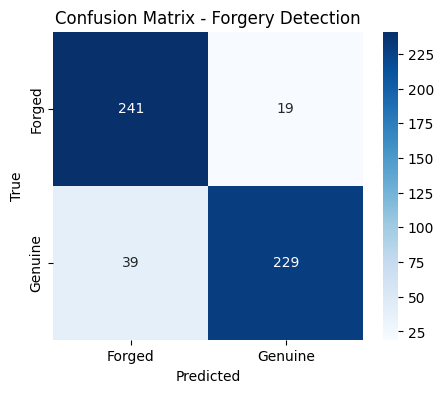

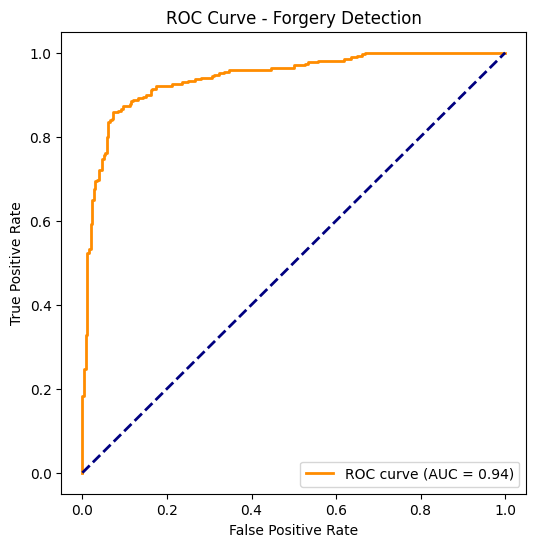

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model

# ---------------------------
# Load dataset
# ---------------------------
data = np.load("signatures_dataset.npz", allow_pickle=True)

X = data["X"]
y_person_ids = data["person_ids"]
y_genuine = data["is_genuine"]

num_persons = len(np.unique(y_person_ids))

# Train/test split (same as training!)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y_persons_oh = to_categorical(y_person_ids - 1, num_classes=num_persons)
y_genuine_oh = to_categorical(y_genuine, num_classes=2)

X_train, X_test, y_persons_train, y_persons_test, y_genuine_train, y_genuine_test = train_test_split(
    X, y_persons_oh, y_genuine_oh, test_size=0.2, random_state=42, stratify=y_person_ids
)

# ---------------------------
# Load the saved model
# ---------------------------
model = load_model("signature_verification_model.h5")

# ---------------------------
# Evaluate
# ---------------------------
print("🔹 Model Evaluation on Test Set")
eval_results = model.evaluate(X_test, {"person_output": y_persons_test, "genuine_output": y_genuine_test})
print(eval_results)

# ---------------------------
# Predictions
# ---------------------------
y_pred_person, y_pred_genuine = model.predict(X_test)

y_true_person = np.argmax(y_persons_test, axis=1)
y_pred_person_cls = np.argmax(y_pred_person, axis=1)

y_true_genuine = np.argmax(y_genuine_test, axis=1)
y_pred_genuine_cls = np.argmax(y_pred_genuine, axis=1)

# ---------------------------
# Reports
# ---------------------------
print("\n📌 Person Classification Report")
print(classification_report(y_true_person, y_pred_person_cls))

print("\n📌 Forgery Detection Report")
print(classification_report(y_true_genuine, y_pred_genuine_cls))

# Confusion Matrix (Forgery)
cm = confusion_matrix(y_true_genuine, y_pred_genuine_cls)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Forged","Genuine"], yticklabels=["Forged","Genuine"])
plt.title("Confusion Matrix - Forgery Detection")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------------------------
# ROC Curve (Forgery Detection)
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_true_genuine, y_pred_genuine[:,1])  # class 1 = Genuine
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Forgery Detection")
plt.legend(loc="lower right")
plt.show()


<h2> Gradio UI

In [13]:
import gradio as gr
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from PIL import Image

# --------------------------
# Load metadata.csv for mapping
# --------------------------
metadata = pd.read_csv("/metadata.csv")
metadata = metadata.drop_duplicates(subset=["person_id"])
person_name_map = dict(zip(metadata["person_id"], metadata["person_name"]))

# --------------------------
# Load model
# --------------------------
model = load_model("signature_verification_model.h5")

# --------------------------
# Prediction function
# --------------------------
def predict_signature(image):
    # Preprocess
    img = image.convert("L").resize((128, 128))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=(0, -1))

    # Predictions
    pred_person, pred_forgery = model.predict(img)

    # Person Prediction
    pred_person_idx = int(np.argmax(pred_person))
    pred_person_name = person_name_map.get(pred_person_idx, f"Unknown ID {pred_person_idx}")

    # Forgery Prediction
    forgery_status = "Genuine" if np.argmax(pred_forgery) == 1 else "Forged"

    # Final formatted output
    result = f"Person Name : {pred_person_name}\nStatus      : {forgery_status}"
    return result

# --------------------------
# Gradio UI
# --------------------------
iface = gr.Interface(
    fn=predict_signature,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Prediction Result"),
    title="Signature Verification"
)

iface.launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fa43d020ac2f307a6f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
